# 深度学习

Author: [shikanon](!https://github.com/shikanon)

## 一、基础篇

神经网络中的每个*神经元* 对其所有的输入进行加权求和，并添加一个被称为*偏置（bias）* 的常数，然后通过一些非线性激活函数来反馈结果。

### 1. softmax
softmax主要用来做多分类问题，是logistic回归模型在多分类问题上的推广，softmax 公式：
<img src='http://img.blog.csdn.net/20161013124320607'>

当k=2时，转换为逻辑回归形式。

softmax 公式示意图：
<img src='./img/softmax-regression-scalargraph.png' style='width: 50%;'>


softmax一般作为神经网络最后一层，作为输出层进行多分类，Softmax的输出的每个值都是>=0，并且其总和为1，所以可以认为其为概率分布。

softmax 示意图
<img src='https://pic3.zhimg.com/v2-998ddf16795db98b980443db952731c2_b.jpg'>




In [2]:
from IPython.display import SVG
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Reshape
from keras.optimizers import SGD, Adam
from keras.utils.visualize_util import model_to_dot
from keras.utils import np_utils
import tensorflow as tf

Using TensorFlow backend.


In [3]:
#设置随机数种子,保证实验可重复
import numpy as np
np.random.seed(0)
#设置线程
THREADS_NUM = 20
tf.ConfigProto(intra_op_parallelism_threads=THREADS_NUM)

(X_train, Y_train),(X_test, Y_test) = mnist.load_data()
print('原数据结构：')
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

#数据变换
#分为10个类别
nb_classes = 10

x_train_1 = X_train.reshape(60000, 784)
#x_train_1 /= 255
#x_train_1 = x_train_1.astype('float32')
y_train_1 = np_utils.to_categorical(Y_train, nb_classes)
print('变换后的数据结构：')
print(x_train_1.shape, y_train_1.shape)

x_test_1 = X_test.reshape(10000, 784)
y_test_1 = np_utils.to_categorical(Y_test, nb_classes)
print(x_test_1.shape, y_test_1.shape)

原数据结构：
((60000, 28, 28), (60000,))
((10000, 28, 28), (10000,))
变换后的数据结构：
((60000, 784), (60000, 10))
((10000, 784), (10000, 10))


In [5]:
# 构建一个softmax模型
# neural network with 1 layer of 10 softmax neurons
#
# · · · · · · · · · ·       (input data, flattened pixels)       X [batch, 784]        # 784 = 28 * 28
# \x/x\x/x\x/x\x/x\x/    -- fully connected layer (softmax)      W [784, 10]     b[10]
#   · · · · · · · ·                                              Y [batch, 10]

# The model is:
#
# Y = softmax( X * W + b)
#              X: matrix for 100 grayscale images of 28x28 pixels, flattened (there are 100 images in a mini-batch)
#              W: weight matrix with 784 lines and 10 columns
#              b: bias vector with 10 dimensions
#              +: add with broadcasting: adds the vector to each line of the matrix (numpy)
#              softmax(matrix) applies softmax on each line
#              softmax(line) applies an exp to each value then divides by the norm of the resulting line
#              Y: output matrix with 100 lines and 10 columns

model = Sequential()
model.add(Dense(nb_classes, input_shape=(784,)))#全连接，输入784维度, 输出10维度，需要和输入输出对应
model.add(Activation('softmax'))

sgd = SGD(lr=0.005)
#binary_crossentropy，就是交叉熵函数
model.compile(loss='binary_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

#model 概要
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_1 (Dense)                  (None, 10)            7850        dense_input_1[0][0]              
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 10)            0           dense_1[0][0]                    
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
____________________________________________________________________________________________________


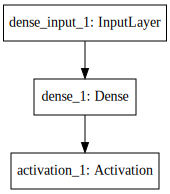

In [6]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [8]:
from keras.callbacks import Callback, TensorBoard
import tensorflow as tf

#构建一个记录的loss的回调函数
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

# 构建一个自定义的TensorBoard类，专门用来记录batch中的数据变化
class BatchTensorBoard(TensorBoard):
    def __init__(self,log_dir='./logs',
                 histogram_freq=0,
                 write_graph=True,
                 write_images=False):
        super(BatchTensorBoard, self).__init__()
        self.log_dir = log_dir
        self.histogram_freq = histogram_freq
        self.merged = None
        self.write_graph = write_graph
        self.write_images = write_images
        self.batch = 0
        self.batch_queue = set()
    
    def on_epoch_end(self, epoch, logs=None):
        pass
    
    def on_batch_end(self,batch,logs=None):
        logs = logs or {}
        
        self.batch = self.batch + 1
        
        for name, value in logs.items():
            if name in ['batch', 'size']:
                continue
            summary = tf.Summary()
            summary_value = summary.value.add()
            summary_value.simple_value = float(value)
            summary_value.tag = "batch_" + name
            if (name,self.batch) in self.batch_queue:
                continue
            self.writer.add_summary(summary, self.batch)
            self.batch_queue.add((name,self.batch))
        self.writer.flush()

In [54]:
tensorboard = TensorBoard(log_dir='/home/tensorflow/log/softmax/epoch')
my_tensorboard = BatchTensorBoard(log_dir='/home/tensorflow/log/softmax/batch')

model.fit(x_train_1, y_train_1,
          nb_epoch=20,
          verbose=0,
          batch_size=100,
          callbacks=[tensorboard, my_tensorboard])

### 损失函数

**损失函数（loss function）**，是指一种将一个事件（在一个样本空间中的一个元素）映射到一个表达与其事件相关的经济成本或机会成本的实数上的一种函数，在统计学中损失函数是一种衡量损失和错误（这种损失与“错误地”估计有关，如费用或者设备的损失）程度的函数。

**交叉熵（cross-entropy）**就是神经网络中常用的损失函数。

交叉熵性质：

（1）非负性。

（2）当真实输出a与期望输出y接近的时候，代价函数接近于0.(比如y=0，a～0；y=1，a~1时，代价函数都接近0)。

<img src='http://img.mp.itc.cn/upload/20170124/9fe5ab61209c490297769b729a471c81_th.jpeg'>

一个比较简单的理解就是使得 预测值Yi和真实值Y' 对接近，即两者的乘积越大，coss-entropy越小。

交叉熵和准确度变化图像可以看 **TensorBoard** 。

### 梯度下降

如果对于所有的权重和所有的偏置计算交叉熵的偏导数，就得到一个对于给定图像、标签和当前权重和偏置的「梯度」，如图所示：

<img src='http://img.mp.itc.cn/upload/20170124/b90ff98a395b46e392c21c6ebca0c7d6_th.jpeg'>

我们希望损失函数最小，也就是需要到达交叉熵最小的凹点的低部。在上图中，交叉熵被表示为一个具有两个权重的函数。

而学习速率，即在梯度下降中的步伐大小。

In [72]:
#模型的测试误差指标
print(model.metrics_names)
# 对测试数据进行测试
model.evaluate(x_test_1, y_test_1,
          verbose=1,
          batch_size=100)

['loss', 'acc']
 9800/10000 [============================>.] - ETA: 0s 

[0.87580669939517974, 0.94387999653816224]

-----------------

上面，我们探索了softmax对多分类的支持和理解，知道softmax可以作为一个输出成层进行多分类任务。

但是，这种分类任务解决的都是线性因素形成的问题，对于非线性的，特别是异或问题，如何解决呢？

这时，一种包含多层隐含层的深度神经网络的概念被提出。

### 3. 激活函数

**激活函数（activation function）**可以使得模型加入非线性因素的。

解决非线性问题有两个办法：线性变换、引入非线性函数。

**（1）线性变换(linear transformation)**

原本一个线性不可分的模型如：X^2 + Y^2 = 1
<img src='https://pic4.zhimg.com/7c88498a754cc7766217e2a57370be03_b.jpg'>

将坐标轴进行高维变换，变成X^2和 Y^2，这是表达式变为了X + Y = 1，这是他就变成了一个线性可分的问题。
<img src='https://pic1.zhimg.com/04cccf522b8d0fb403c64bd6db53d204_b.jpg'>

**（2）引入非线性函数**

一个典型的异或问题：
<img src='https://pic3.zhimg.com/8a5b88d6beda0c6ed79721ca709030fa_b.jpg'>
x = 1, y = 1, 则 z = 0
x = 0, y = 0, 则 z = 0
x = 1, y = 0, 则 z = 1
x = 0, y = 1, 则 z = 1

如何构建一个f()，使得：f(x,y)=z呢？

...

----------------

经典的神经网络解决方案：

<img src='https://pic4.zhimg.com/d45f15128c401f6d7b8ae8a0b2fb2967_b.jpg'>

(线上的数值为权重值，单元圈中的数值为阈值)

构建两个隐藏层，使用逻辑回归函数。

第一层激活单元（阈值为t）

```
if a >= t:
    h(a) = a
else:
    h(a) = 0
```

第二层的阈值为1.5,第三层阈值为0.5

最后一层输出的权重值:

<img src='https://pic4.zhimg.com/2c54fea477b3960172874202e7c47657_b.jpg'>

图形化解释：

经过变换后的数据是线性可分的（n维，比如本例中可以用平面）
<img src='https://pic1.zhimg.com/3bf44923c05ef7e4ba6407aee8d2d938_b.jpg'>


一个可视化演示网址：

http://playground.tensorflow.org/

可以自己建立一个小型神经网络帮助理解。


### 3. sigmoid

sigmoid是一个用来做二分类的"S"形逻辑回归曲线

sigmoid公式：
<img src='http://d.hiphotos.baidu.com/baike/s%3D99/sign=a46bd6f1dd33c895a27e9472d01340df/0df3d7ca7bcb0a4659502a5f6f63f6246b60af62.jpg'>

sigmoid图像：
<img src='http://img.blog.csdn.net/20161013123019537'>

其抑制两头,对中间细微变化敏感，因此sigmoid函数作为最简单常用的神经网络激活层被使用。

优点：

（1）输出范围(0,1)，数据在传递的过程中不容易发散

（2）单向递增

（3）易求导

sigmod有个缺点，sigmoid函数反向传播时，很容易就会出现梯度消失,在接近饱和区的时候，导数趋向0，会变得非常缓慢。因此，在优化器选择时选用Adam优化器。

Adam 也是基于梯度下降的方法，但是每次迭代参数的学习步长都有一个确定的范围，不会因为很大的梯度导致很大的学习步长，参数的值比较稳定。有利于降低模型收敛到局部最优的风险，而SGD容易收敛到局部最优，**如果下面代码中的optimizer改成SGD的化，在一次epoch后就acc值不会改变了，陷入局部最优**



In [46]:

# 构建一个五层sigmod全连接神经网络
# neural network with 5 layers
#
# · · · · · · · · · ·       (input data, flattened pixels)       X [batch, 784]   # 784 = 28*28
# \x/x\x/x\x/x\x/x\x/    -- fully connected layer (sigmoid)      W1 [784, 200]      B1[200]
#  · · · · · · · · ·                                             Y1 [batch, 200]
#   \x/x\x/x\x/x\x/      -- fully connected layer (sigmoid)      W2 [200, 100]      B2[100]
#    · · · · · · ·                                               Y2 [batch, 100]
#    \x/x\x/x\x/         -- fully connected layer (sigmoid)      W3 [100, 60]       B3[60]
#     · · · · ·                                                  Y3 [batch, 60]
#     \x/x\x/            -- fully connected layer (sigmoid)      W4 [60, 30]        B4[30]
#      · · ·                                                     Y4 [batch, 30]
#      \x/               -- fully connected layer (softmax)      W5 [30, 10]        B5[10]
#       ·                                                        Y5 [batch, 10]

model = Sequential()
model.add(Dense(200, input_shape=(784,)))#全连接，输入784维度, 输出10维度，需要和输入输出对应
model.add(Activation('sigmoid'))
model.add(Dense(100))# 除了首层需要设置输入维度，其他层只需要输入输出维度就可以了，输入维度自动继承上层。
model.add(Activation('sigmoid'))
model.add(Dense(60))
model.add(Activation('sigmoid'))
model.add(Dense(30))            #model.add(Activation('sigmoid'))和model.add(Dense(30))可以合并写出
model.add(Activation('sigmoid'))#model.add(Dense(30,activation='softmax'))
model.add(Dense(10))
model.add(Activation('softmax'))

sgd = Adam(lr=0.003)
model.compile(loss='binary_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

#model 概要
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_23 (Dense)                 (None, 200)           157000      dense_input_7[0][0]              
____________________________________________________________________________________________________
activation_23 (Activation)       (None, 200)           0           dense_23[0][0]                   
____________________________________________________________________________________________________
dense_24 (Dense)                 (None, 100)           20100       activation_23[0][0]              
____________________________________________________________________________________________________
activation_24 (Activation)       (None, 100)           0           dense_24[0][0]                   
___________________________________________________________________________________________

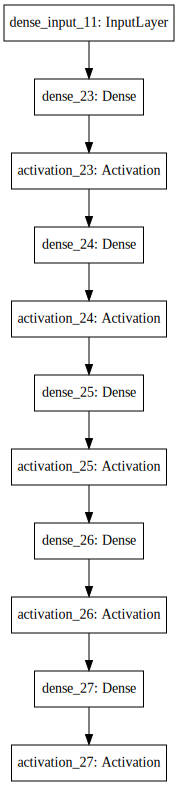

In [77]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [78]:
tensorboard2 = TensorBoard(log_dir='/home/tensorflow/log/five_layer/epoch', histogram_freq=0)
my_tensorboard2 = BatchTensorBoard(log_dir='/home/tensorflow/log/five_layer/batch')
model.fit(x_train_1, y_train_1,
          nb_epoch=20,
          verbose=0,
          batch_size=100,
          callbacks=[my_tensorboard2, tensorboard2])

In [79]:
#模型的测试误差指标
print(model.metrics_names)
# 对测试数据进行测试
model.evaluate(x_test_1, y_test_1,
          verbose=1,
          batch_size=100)

['loss', 'acc']
 9800/10000 [============================>.] - ETA: 0s 

[0.036339853547979147, 0.98736999988555907]

--------------------

根据上面，我们可以看出，深度越深，效果越好。

但是，对于深层网络，sigmoid函数反向传播时，很容易就会出现梯度消失的情况从而无法完成深层网络的训练。在sigmoid接近饱和区时，变换非常缓慢，导数趋于0，减缓收敛速度。

### 4. ReLu

修正线性单元(Rectified linear unit,ReLU)公式：

<img src='https://wikimedia.org/api/rest_v1/media/math/render/svg/3748c43adcce6520cc09f8e5259f6b9db371cbe8'>

其图像：

<img src='http://img.it610.com/image/info5/bed97ea828ee413482b82cff26411518.jpg'>

ReLU具有线性、非饱和性，而其非饱和性使得网络可以自行引入稀疏性。

ReLU的使用解决了sigmoid梯度下降慢，深层网络的信息丢失的问题。

ReLU在训练时是非常脆弱的，并且可能会“死”。例如，经过ReLU神经元的一个大梯度可能导致权重更新后该神经元接收到任何数据点都不会再激活。如果发生这种情况，之后通过该单位点的梯度将永远是零。也就是说，ReLU可能会在训练过程中不可逆地死亡，并且破坏数据流形。如果学习率太高，大部分网络将会“死亡”（即，在整个训练过程中神经元都没有激活）。而设置一个适当的学习率，可以在一定程度上避免这一问题。

### 5. 学习速率

上面说梯度下降的时候，说过学习速率其实就是梯度下降的步伐。因此，为了到达山谷，需要控制步伐的大小，即学习速率。

学习速率大小的调节一般取决于 loss 的变化幅度。


In [62]:
# neural network with 5 layers
#
# · · · · · · · · · ·       (input data, flattened pixels)       X [batch, 784]   # 784 = 28*28
# \x/x\x/x\x/x\x/x\x/    -- fully connected layer (relu)         W1 [784, 200]      B1[200]
#  · · · · · · · · ·                                             Y1 [batch, 200]
#   \x/x\x/x\x/x\x/      -- fully connected layer (relu)         W2 [200, 100]      B2[100]
#    · · · · · · ·                                               Y2 [batch, 100]
#    \x/x\x/x\x/         -- fully connected layer (relu)         W3 [100, 60]       B3[60]
#     · · · · ·                                                  Y3 [batch, 60]
#     \x/x\x/            -- fully connected layer (relu)         W4 [60, 30]        B4[30]
#      · · ·                                                     Y4 [batch, 30]
#      \x/               -- fully connected layer (softmax)      W5 [30, 10]        B5[10]
#       ·                                                        Y5 [batch, 10]
model = Sequential()
model.add(Dense(200, input_shape=(784,)))#全连接，输入784维度, 输出10维度，需要和输入输出对应
model.add(Activation('relu'))# 将激活函数sigmoid改为ReLU
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dense(60))
model.add(Activation('relu'))
model.add(Dense(30))            
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('softmax'))

sgd = Adam(lr=0.003)
model.compile(loss='binary_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

#model 概要
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_14 (Dense)                 (None, 200)           157000      dense_input_6[0][0]              
____________________________________________________________________________________________________
activation_14 (Activation)       (None, 200)           0           dense_14[0][0]                   
____________________________________________________________________________________________________
dense_15 (Dense)                 (None, 100)           20100       activation_14[0][0]              
____________________________________________________________________________________________________
activation_15 (Activation)       (None, 100)           0           dense_15[0][0]                   
___________________________________________________________________________________________

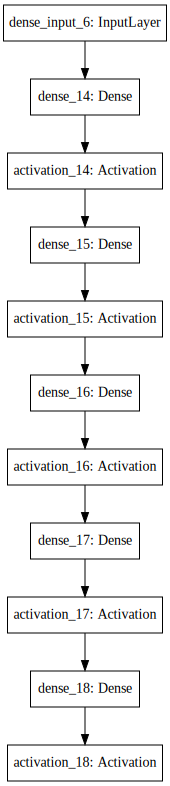

In [63]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [64]:
tensorboard3 = TensorBoard(log_dir='/home/tensorflow/log/five_layer_relu/epoch', histogram_freq=0)
my_tensorboard3 = BatchTensorBoard(log_dir='/home/tensorflow/log/five_layer_relu/batch')
model.fit(x_train_1, y_train_1,
          nb_epoch=20,
          verbose=0,
          batch_size=100,
          callbacks=[my_tensorboard3, tensorboard3])

In [ ]:
#模型的测试误差指标
print(model.metrics_names)
# 对测试数据进行测试
model.evaluate(x_test_1, y_test_1,
          verbose=1,
          batch_size=100)

### 7.Dropout

--------------------

运行目录下的mnist_2.1_five_layers_relu_lrdecay.py

效果图：

<img src='./img/mnist_2.1_five_layers_relu_lrdecay.png' style='width: 50%'>

可以看到在4000次迭代之后，test loss 和 train loss 差距越来越大，模型开始过拟合。

Dropout是指对于神经网络单元按照一定的概率将其暂时从网络中丢弃,从而解决过拟合问题。

<img src='./img/dropout-1.png' style='width: 50%'>

In [13]:
# neural network with 5 layers
#
# · · · · · · · · · ·       (input data, flattened pixels)       X [batch, 784]   # 784 = 28*28
# \x/x\x/x\x/x\x/x\x/ ✞  -- fully connected layer (relu+dropout) W1 [784, 200]      B1[200]
#  · · · · · · · · ·                                             Y1 [batch, 200]
#   \x/x\x/x\x/x\x/ ✞    -- fully connected layer (relu+dropout) W2 [200, 100]      B2[100]
#    · · · · · · ·                                               Y2 [batch, 100]
#    \x/x\x/x\x/ ✞       -- fully connected layer (relu+dropout) W3 [100, 60]       B3[60]
#     · · · · ·                                                  Y3 [batch, 60]
#     \x/x\x/ ✞          -- fully connected layer (relu+dropout) W4 [60, 30]        B4[30]
#      · · ·                                                     Y4 [batch, 30]
#      \x/               -- fully connected layer (softmax)      W5 [30, 10]        B5[10]
#       ·                                                        Y5 [batch, 10]
model = Sequential()
model.add(Dense(200, input_shape=(784,)))#全连接，输入784维度, 输出10维度，需要和输入输出对应
model.add(Activation('relu'))# 将激活函数sigmoid改为ReLU
model.add(Dropout(0.25))# 添加一个dropout层, 随机移除25%的单元
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(60))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(30))            
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(10))
model.add(Activation('softmax'))

sgd = Adam(lr=0.003)
model.compile(loss='binary_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

#model 概要
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_11 (Dense)                 (None, 200)           157000      dense_input_3[0][0]              
____________________________________________________________________________________________________
activation_11 (Activation)       (None, 200)           0           dense_11[0][0]                   
____________________________________________________________________________________________________
dropout_9 (Dropout)              (None, 200)           0           activation_11[0][0]              
____________________________________________________________________________________________________
dense_12 (Dense)                 (None, 100)           20100       dropout_9[0][0]                  
___________________________________________________________________________________________

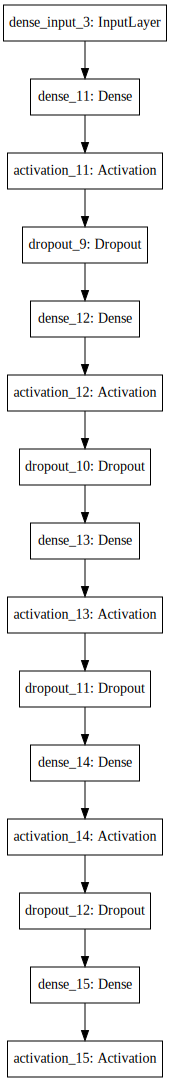

In [14]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [15]:
tensorboard4 = TensorBoard(log_dir='/home/tensorflow/log/five_layer_dropout/epoch')
my_tensorboard4 = BatchTensorBoard(log_dir='/home/tensorflow/log/five_layer_dropout/batch')

model.fit(x_train_1, y_train_1,
          nb_epoch=20,
          verbose=0,
          batch_size=100,
          callbacks=[tensorboard4, my_tensorboard4])

In [16]:
#模型的测试误差指标
print(model.metrics_names)
# 对测试数据进行测试
model.evaluate(x_test_1, y_test_1,
          verbose=1,
          batch_size=100)

['loss', 'acc']
 9900/10000 [============================>.] - ETA: 0s

[2.8421609926223756, 0.82270000338554383]